In [7]:
!pip install numpy-financial

In [8]:
import numpy as np
import numpy_financial as npf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

In [9]:
# Assumptions

# Basic LBO timeline
projection_years = 6   # We'll model a 6-year holding period
iterations = 40000     # Monte Carlo simulations

# Operating assumptions
current_ebitda = 15.0          # Current EBITDA (in millions)
ebitda_margin = 0.22           # For reference if needed in more advanced models

# Growth & exit assumptions (treated as random)
ebitda_growth_mean = 0.05      # 5% annual EBITDA growth on average
ebitda_growth_std = 0.015      # 1.5% standard deviation for growth
exit_multiple_mean = 7.8       # Average exit EV/EBITDA multiple
exit_multiple_std = 0.6        # Standard deviation for exit multiple

# Purchase assumptions
purchase_multiple = 7.2        # Entry EV/EBITDA multiple
equity_contribution_ratio = 0.30  # 30% of purchase price financed by equity, rest by debt

# Debt & interest assumptions (treated as random for Monte Carlo)
base_interest_rate = 0.055     # 5.5% average interest rate
interest_rate_std = 0.008      # 0.8% standard deviation

# Simplified cash flow assumptions
tax_rate = 0.28                # 28% corporate tax
capex_percent = 0.035          # 3.5% of EBITDA for CapEx
depr_percent = 0.03            # 3% as a simplified depreciation rate
nwc_percent = 0.18             # 18% for net working capital

# Debt repayment policy:
# We'll assume any free cash flow after interest & taxes is used to pay down principal.

In [10]:
def run_lbo_mc_sim(
    projection_years,
    iterations,
    current_ebitda,
    purchase_multiple,
    equity_contribution_ratio,
    ebitda_growth_mean,
    ebitda_growth_std,
    exit_multiple_mean,
    exit_multiple_std,
    base_interest_rate,
    interest_rate_std,
    tax_rate,
    capex_percent,
    depr_percent,
    nwc_percent
):
    # 1. Random draws for each iteration
    growth_draws = np.random.normal(ebitda_growth_mean, ebitda_growth_std, (projection_years, iterations))
    exit_multiples = np.random.normal(exit_multiple_mean, exit_multiple_std, iterations)
    interest_rates = np.random.normal(base_interest_rate, interest_rate_std, iterations)

    # 2. Entry purchase price
    entry_ev = current_ebitda * purchase_multiple
    equity_portion = entry_ev * equity_contribution_ratio
    debt_portion = entry_ev - equity_portion  # remainder is debt

    # 3. Prepare array to store IRRs
    irr_array = np.zeros(iterations)

    # 4. Loop through each simulation
    for i in range(iterations):
        # Pull the random values for this iteration
        current_interest_rate = interest_rates[i]
        current_exit_mult = exit_multiples[i]

        # Start with current EBITDA
        ebitda_t = current_ebitda

        # Track outstanding debt
        debt_outstanding = debt_portion

        # Track sponsor's annual cash flows for IRR (size: projection_years + 1)
        # At t=0, sponsor invests equity (negative cash flow)
        sponsor_cf = np.zeros(projection_years + 1)
        sponsor_cf[0] = -equity_portion

        # For each year, project EBITDA growth, calculate free cash flow, pay down debt
        for t in range(projection_years):
            # Update EBITDA
            ebitda_t *= (1 + growth_draws[t, i])

            # Approximate EBIT:
            # Let's treat depreciation as a fraction of EBITDA or some simplified approach
            depreciation = ebitda_t * (depr_percent / ebitda_margin)  # This is just a rough approach
            ebit = ebitda_t - depreciation

            # Taxes
            tax_payment = max(0, ebit) * tax_rate

            # Interest expense
            interest_expense = debt_outstanding * current_interest_rate

            # Net income (roughly)
            net_income = ebit - tax_payment - interest_expense

            # Operating cash flow: net income + depreciation
            operating_cf = net_income + depreciation

            # CapEx (negative outflow)
            capex = - (ebitda_t * capex_percent)

            # Change in net working capital (simplified as some fraction of EBITDA growth)
            # For example, let's assume NWC grows at 5% of the incremental EBITDA
            nwc_increase = ebitda_t * nwc_percent * 0.05

            # Free cash flow after interest
            fcf = operating_cf + capex - nwc_increase

            # Use FCF to pay down debt
            if fcf > 0:
                if fcf >= debt_outstanding:
                    # Enough to fully pay off debt
                    fcf_after_debt = fcf - debt_outstanding
                    debt_outstanding = 0
                else:
                    debt_outstanding -= fcf
                    fcf_after_debt = 0
            else:
                # Negative or zero FCF => no debt paydown
                fcf_after_debt = fcf

            # Whatever remains after debt repayment is sponsor's cash flow
            sponsor_cf[t + 1] = fcf_after_debt

        # 5. At the end of the holding period, sponsor sells the company
        exit_ev = ebitda_t * current_exit_mult

        # Equity value at exit = exit EV - remaining debt
        exit_equity_value = exit_ev - debt_outstanding

        # Add exit proceeds to the final year's sponsor cash flow
        sponsor_cf[-1] += exit_equity_value

        # 6. Calculate IRR using numpy_financial.irr
        iteration_irr = npf.irr(sponsor_cf)
        irr_array[i] = iteration_irr

    return irr_array

In [11]:
irr_sims = run_lbo_mc_sim(
    projection_years=projection_years,
    iterations=iterations,
    current_ebitda=current_ebitda,
    purchase_multiple=purchase_multiple,
    equity_contribution_ratio=equity_contribution_ratio,
    ebitda_growth_mean=ebitda_growth_mean,
    ebitda_growth_std=ebitda_growth_std,
    exit_multiple_mean=exit_multiple_mean,
    exit_multiple_std=exit_multiple_std,
    base_interest_rate=base_interest_rate,
    interest_rate_std=interest_rate_std,
    tax_rate=tax_rate,
    capex_percent=capex_percent,
    depr_percent=depr_percent,
    nwc_percent=nwc_percent
)

In [12]:
irr_mean = np.mean(irr_sims)
irr_median = np.median(irr_sims)
irr_std = np.std(irr_sims)
irr_min = np.min(irr_sims)
irr_max = np.max(irr_sims)
irr_5th = np.percentile(irr_sims, 5)
irr_95th = np.percentile(irr_sims, 95)

In [13]:
irr_sims_pct = irr_sims * 100
mean_pct = irr_mean * 100
median_pct = irr_median * 100
std_pct = irr_std * 100
min_pct = irr_min * 100
max_pct = irr_max * 100
p5_pct = irr_5th * 100
p95_pct = irr_95th * 100

In [14]:
lower68 = mean_pct - std_pct
upper68 = mean_pct + std_pct

lower95 = mean_pct - 2 * std_pct
upper95 = mean_pct + 2 * std_pct

In [15]:
summary_data = {
    "Metric": ["Mean IRR", "Median IRR", "Std Dev", "Min IRR", "Max IRR", "5th Percentile", "95th Percentile"],
    "Value (%)": [mean_pct, median_pct, std_pct, min_pct, max_pct, p5_pct, p95_pct]
}
summary_df = pd.DataFrame(summary_data)
print("LBO IRR Simulation Summary:")
print(summary_df)

LBO IRR Simulation Summary:
            Metric  Value (%)
0         Mean IRR  27.471423
1       Median IRR  27.541055
2          Std Dev   2.207941
3          Min IRR  16.209221
4          Max IRR  36.856660
5   5th Percentile  23.715445
6  95th Percentile  30.994984


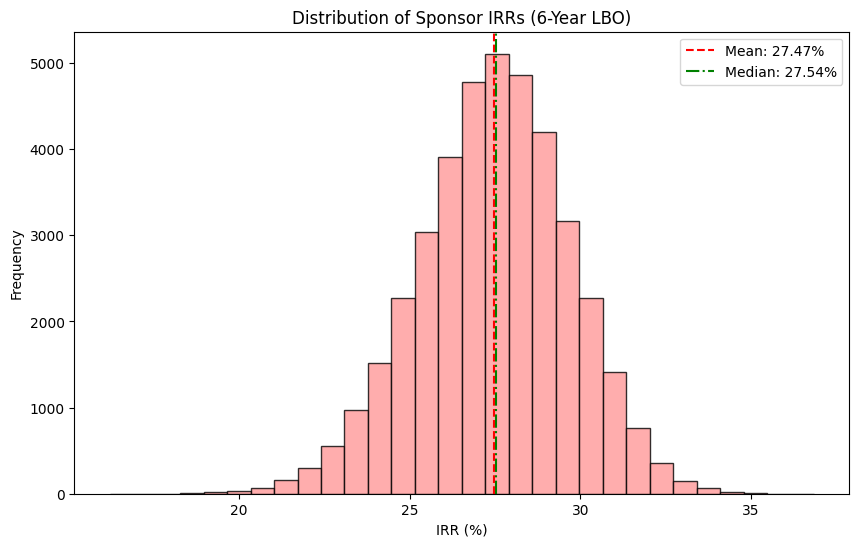

In [17]:
# Histogram of IRRs
plt.figure(figsize=(10, 6))
plt.hist(irr_sims_pct, bins=30, color='#FF9999', edgecolor='black', alpha=0.8)
plt.title("Distribution of Sponsor IRRs (6-Year LBO)")
plt.xlabel("IRR (%)")
plt.ylabel("Frequency")
plt.axvline(mean_pct, color='red', linestyle='dashed', linewidth=1.5, label=f"Mean: {mean_pct:.2f}%")
plt.axvline(median_pct, color='green', linestyle='dashdot', linewidth=1.5, label=f"Median: {median_pct:.2f}%")
plt.legend()
plt.show()

In [18]:
# Detailed Report

print(f"\n# *** LBO Model - {projection_years}-Year Monte Carlo Simulation ***")
print(f"Iterations: {iterations:,d}")
print("\n## Key Assumptions:")
print(f"Purchase Multiple: x{purchase_multiple:.2f}")
print(f"Equity Contribution: {equity_contribution_ratio*100:.1f}% of Purchase Price")
print(f"Base Interest Rate: {base_interest_rate*100:.1f}% (Std: {interest_rate_std*100:.1f}%)")
print(f"EBITDA Growth: {ebitda_growth_mean*100:.1f}% (Std: {ebitda_growth_std*100:.1f}%)")
print(f"Exit Multiple (mean): x{exit_multiple_mean:.1f} (Std: {exit_multiple_std:.1f})")
print(f"Tax Rate: {tax_rate*100:.1f}%")
print(f"Capex: {capex_percent*100:.1f}% of EBITDA | Depreciation: {depr_percent*100:.1f}% | NWC: {nwc_percent*100:.1f}% (simplified)")
print(f"Projection Period: {projection_years} years\n")

print("## IRR Outcomes:")
print(f"Mean IRR: {mean_pct:.2f}%")
print(f"Median IRR: {median_pct:.2f}%")
print(f"Std Dev: {std_pct:.2f}%")
print(f"5th Percentile IRR: {p5_pct:.2f}% | 95th Percentile IRR: {p95_pct:.2f}%")
print(f"Min IRR: {min_pct:.2f}% | Max IRR: {max_pct:.2f}%")
print(f"Approx 68% Range: {lower68:.2f}% - {upper68:.2f}%")
print(f"Approx 95% Range: {lower95:.2f}% - {upper95:.2f}%")


# *** LBO Model - 6-Year Monte Carlo Simulation ***
Iterations: 40,000

## Key Assumptions:
Purchase Multiple: x7.20
Equity Contribution: 30.0% of Purchase Price
Base Interest Rate: 5.5% (Std: 0.8%)
EBITDA Growth: 5.0% (Std: 1.5%)
Exit Multiple (mean): x7.8 (Std: 0.6)
Tax Rate: 28.0%
Capex: 3.5% of EBITDA | Depreciation: 3.0% | NWC: 18.0% (simplified)
Projection Period: 6 years

## IRR Outcomes:
Mean IRR: 27.47%
Median IRR: 27.54%
Std Dev: 2.21%
5th Percentile IRR: 23.72% | 95th Percentile IRR: 30.99%
Min IRR: 16.21% | Max IRR: 36.86%
Approx 68% Range: 25.26% - 29.68%
Approx 95% Range: 23.06% - 31.89%
